In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage.filters import uniform_filter1d

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
warnings.filterwarnings('ignore')

In [4]:
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.25deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

In [5]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds_1DRM.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds_1DRM.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds_1DRM.dat'))

In [6]:
os.chdir('/data/willytsai/TQUV_3hr/')
files = glob('*.nc')
lev = xr.open_dataset(files[0]).T.lev # MERRA2 standard level 
del files
os.chdir('/data/willytsai/Cloudfrac_3hr/')
lev_m = np.loadtxt('model_lev.txt')[:,1]# MERRA2 model level, 58 levs [72-15]

In [7]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event < lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event < lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [8]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

### 0. select specific oceanic regions

In [9]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [10]:
idx_region = event_region(lat_event, lon_event, -180, 180, -10, 10)

In [11]:
time_event = time_event[idx_region]
lat_event = lat_event[idx_region]
lon_event = lon_event[idx_region]

In [12]:
os.chdir('/data/willytsai/ISCCP')

SCAIbt_all = np.load('SCAIbt_all_5deg_4ds_1DRM.mat.npy') #
prec_all = np.load('prec_all_5deg_4ds_1DRM.mat.npy') #
cldfrac_all = np.load('cldfrac_all_5deg_4ds_1DRM.mat.npy') #

In [13]:
idx_rm = np.arange(len(time_event))
idx_cld0 = np.where(cldfrac_all[:,16]==0)[0] # cldfrac = 0
idx_scai = np.where(np.isnan(SCAIbt_all[:,16])==1)[0] # SCAI = NaN

idx_rm = np.setdiff1d(idx_rm, idx_cld0) # remove index with all weird cases
idx_rm = np.setdiff1d(idx_rm, idx_scai) # remove index with all weird cases

In [14]:
time_event = time_event[idx_rm]
lat_event = lat_event[idx_rm]
lon_event = lon_event[idx_rm]

SCAIbt_all = SCAIbt_all[idx_rm]
prec_all = prec_all[idx_rm]
cldfrac_all = cldfrac_all[idx_rm]

In [15]:
prec_bins2 = np.linspace(5,35,4)

In [16]:
## sorting SCAI with fixed range of precip
SCAI_bins = np.linspace(0,20,26)

SCAI_deciles_p = np.zeros((len(prec_bins2)-1,10))

for i in range(len(prec_bins2)-1):
    idx = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins2[i],24*prec_all[:,16]<prec_bins2[i+1]))[0]
    SCAI_tmp = SCAIbt_all[idx,16]
    #idx_sorted = np.argsort(SCAI_sorted)
    
    # SCAI deciles
    SCAI_deciles_p[i,:] = np.percentile(SCAI_tmp,np.arange(0, 100, 10))

In [17]:
# different catagory 
def freq_map_cat(lon_event,lat_event):
   
    lat_bin = np.linspace(-7.5,7.5,7)
    lon_bin = np.linspace(-177.5,177.5,143)

    freq_map = np.zeros((len(lon_bin),len(lat_bin)))

    for i in range(len(lon_bin)):
        for j in range(len(lat_bin)):
            idx = np.where(lon_event == lon_bin[i])[0]
            idy = np.where(lat_event == lat_bin[j])[0]
            
            if (lon_bin[i] >= 90) & (lon_bin[i]<=150): # remove maritime continent
                freq_map[i,j] = np.nan

            if len(np.intersect1d(idx,idy)) > 0:
                freq_map[i,j] += len(np.intersect1d(idx,idy))
    
    freq_map_re = np.zeros((145,7))
    freq_map_re[:143,:] = freq_map
    freq_map_re[143,:] = (freq_map[0,:]+freq_map[-1,:])/2
    freq_map_re[144,:] = (freq_map[0,:]+freq_map[-1,:])/2    
    freq_map_re = np.vstack([freq_map_re.T,np.zeros((freq_map_re.shape[0])).T]).T
    
    return freq_map_re

In [18]:
# record index of SCAI decile for global maps
pscai_idx_g1 = []
pscai_idx_g2 = []
pscai_idx_g3 = []

for i in range(len(prec_bins2)-1):
    idx_p = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins2[i],24*prec_all[:,16]<prec_bins2[i+1]))[0]
    
    for n in range(10):
        if n < 9:
            idx_dec = np.where(np.logical_and(SCAIbt_all[:,16]>= SCAI_deciles_p[i,n],SCAIbt_all[:,16] < SCAI_deciles_p[i,n+1]))[0]
        else:
            idx_dec = np.where(SCAIbt_all[:,16]>= SCAI_deciles_p[i,n])[0]
        idx_com = np.intersect1d(idx_p, idx_dec)
    
        if i == 0:
            pscai_idx_g1.append(idx_com)
        if i == 1:
            pscai_idx_g2.append(idx_com)        
        if i == 2:
            pscai_idx_g3.append(idx_com)


In [19]:
os.chdir('/data2/willytsai/ISCCP')
cwv_data = xr.open_dataset('cwvmap_climatology.nc')
cwv_clim = cwv_data.TQV
prec_data = xr.open_dataset('precmap_climatology.nc')
prec_clim = prec_data.precipitation

# landmask
idx = np.where(np.logical_and(cwv_clim.lon>90, cwv_clim.lon<150))[0]
cwv_clim[:,idx] = np.nan
idx = np.where(np.logical_and(prec_clim.lon>90, prec_clim.lon<150))[0]
prec_clim[:,idx] = np.nan

In [20]:
lat_bin = np.linspace(-8.75,8.75,8)
lon_bin = np.linspace(-178.75,181.25,145)
freq_map = []

freq_map_tot =  freq_map_cat(lon_event,lat_event)
for i in range(10):
    freq_map.append(freq_map_cat(lon_event[pscai_idx_g1[i]],lat_event[pscai_idx_g1[i]]))

In [21]:
cmap_cus = ListedColormap(['white','whitesmoke','lightgrey','darkgrey','royalblue','green','mediumseagreen',
'greenyellow','yellow','gold','orange','darkorange','red','firebrick'])

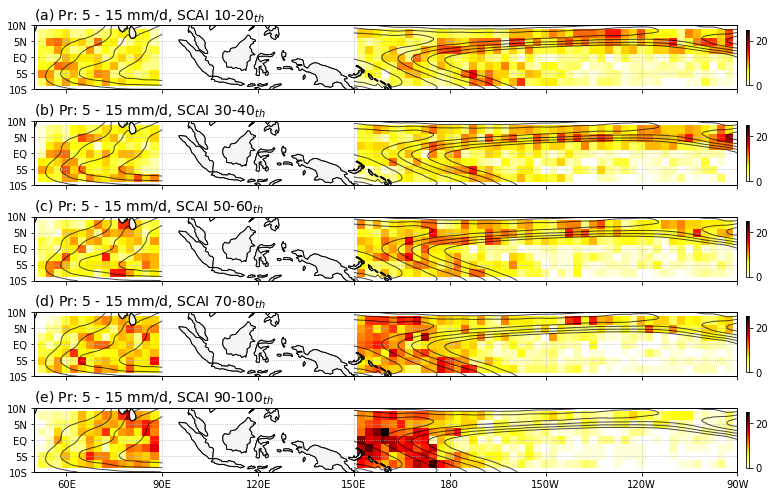

In [46]:
titles = ['(a) Pr: 5 - 15 mm/d, SCAI 10-20$_{th}$','(b) Pr: 5 - 15 mm/d, SCAI 30-40$_{th}$',
          '(c) Pr: 5 - 15 mm/d, SCAI 50-60$_{th}$','(d) Pr: 5 - 15 mm/d, SCAI 70-80$_{th}$',
          '(e) Pr: 5 - 15 mm/d, SCAI 90-100$_{th}$']

fig,ax = plt.subplots(5,1,figsize=(15,8.5)
        ,subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

for i,freq in enumerate([freq_map[1],freq_map[3],freq_map[5],freq_map[7],freq_map[9]]):
    
    ax[i].coastlines()
    ax[i].add_feature(cfeat.LAND,zorder=2,edgecolor='k',facecolor='whitesmoke') # maskout LAND
    ax[i].set_facecolor('snow')
    
#    cf = ax[i].contourf(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
#                       ,cmap=cmap_cus,levels=np.linspace(0,30,11))
    cf = ax[i].pcolormesh(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
                        ,cmap='hot_r',vmax=25)
        
    cwv_con,lon = add_cyclic_point(cwv_clim, coord=cwv_clim.lon)
    ax[i].contour(lon,cwv_clim.lat,cwv_con,transform=ccrs.PlateCarree(),
                levels=[46,48,50,52,54,56],colors=['k'],linewidths=1,alpha=0.7)
    ax[i].set_title(titles[i],fontsize=14,loc='left')
    
#    prec_con,lon = add_cyclic_point(prec_clim, coord=prec_clim.lon)
#    ax[i].contour(lon,prec_clim.lat,24*prec_con,transform=ccrs.PlateCarree(),
#               levels=[1,3,5,7,9,11],colors=['k'],linewidths=1,alpha=0.7)

    ax[i].set_title(titles[i],fontsize=14,loc='left')

    ax[i].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
    ax[i].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
    ax[i].set_xticks([-180,-150,-120,-90,-60,-30,-0,30,60,90,120,150,180])
    if i == 4:
        ax[i].set_xticklabels(['0','30E','60E','90E','120E','150E','180','150W','120W','90W','60W','30W','0'])
    else:
        ax[i].set_xticklabels([])
    ax[i].set_ylim([-10,10]);ax[i].grid(linestyle=':')
    ax[i].set_xlim([-130,90])
    cbar = plt.colorbar(cf,ax=ax[i],shrink=0.7,pad=0.01)

plt.tight_layout(w_pad=2)

In [47]:
lat_bin = np.linspace(-8.75,8.75,8)
lon_bin = np.linspace(-178.75,181.25,145)
freq_map = []

freq_map_tot =  freq_map_cat(lon_event,lat_event)
for i in range(10):
    freq_map.append(freq_map_cat(lon_event[pscai_idx_g3[i]],lat_event[pscai_idx_g3[i]]))

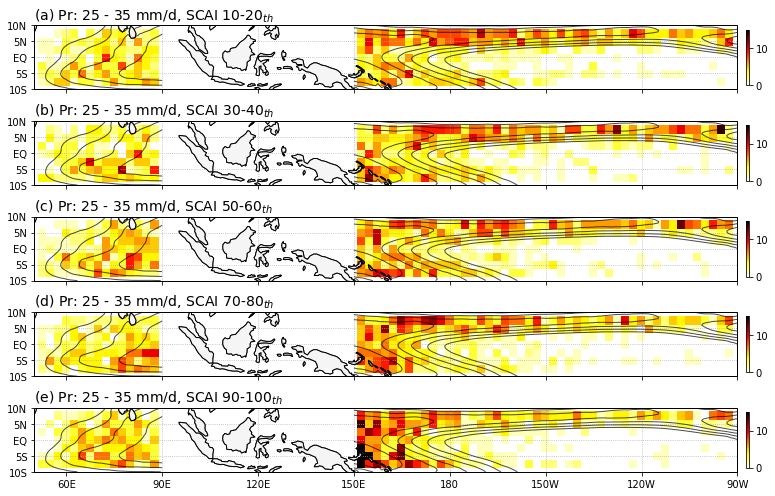

In [49]:
titles = ['(a) Pr: 25 - 35 mm/d, SCAI 10-20$_{th}$','(b) Pr: 25 - 35 mm/d, SCAI 30-40$_{th}$',
          '(c) Pr: 25 - 35 mm/d, SCAI 50-60$_{th}$','(d) Pr: 25 - 35 mm/d, SCAI 70-80$_{th}$',
          '(e) Pr: 25 - 35 mm/d, SCAI 90-100$_{th}$']

fig,ax = plt.subplots(5,1,figsize=(15,8.5)
        ,subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

for i,freq in enumerate([freq_map[1],freq_map[3],freq_map[5],freq_map[7],freq_map[9]]):
    
    ax[i].coastlines()
    ax[i].add_feature(cfeat.LAND,zorder=2,edgecolor='k',facecolor='whitesmoke') # maskout LAND
    ax[i].set_facecolor('snow')
    
#    cf = ax[i].contourf(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
#                       ,cmap=cmap_cus,levels=np.linspace(0,30,11))
    cf = ax[i].pcolormesh(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
                        ,cmap='hot_r',vmax=15)
        
    cwv_con,lon = add_cyclic_point(cwv_clim, coord=cwv_clim.lon)
    ax[i].contour(lon,cwv_clim.lat,cwv_con,transform=ccrs.PlateCarree(),
                levels=[46,48,50,52,54,56],colors=['k'],linewidths=1,alpha=0.7)
    ax[i].set_title(titles[i],fontsize=14,loc='left')
    
#    prec_con,lon = add_cyclic_point(prec_clim, coord=prec_clim.lon)
#    ax[i].contour(lon,prec_clim.lat,24*prec_con,transform=ccrs.PlateCarree(),
#               levels=[1,3,5,7,9,11],colors=['k'],linewidths=1,alpha=0.7)

    ax[i].set_title(titles[i],fontsize=14,loc='left')

    ax[i].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
    ax[i].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
    ax[i].set_xticks([-180,-150,-120,-90,-60,-30,-0,30,60,90,120,150,180])
    if i == 4:
        ax[i].set_xticklabels(['0','30E','60E','90E','120E','150E','180','150W','120W','90W','60W','30W','0'])
    else:
        ax[i].set_xticklabels([])
    ax[i].set_ylim([-10,10]);ax[i].grid(linestyle=':')
    ax[i].set_xlim([-130,90])
    cbar = plt.colorbar(cf,ax=ax[i],shrink=0.7,pad=0.01)

plt.tight_layout(w_pad=2)